In [1]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from scipy.stats import special_ortho_group

# First of all we set a readable font size for the article
plt.rcParams.update({'font.size': 16})

# Set seed
np.random.seed(42)

# Set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = torch.device('cpu')
    print('Using CPU')

# Constants

TEACHER_LAYER_DIM = 20
MAX_STUDENT_HIDDEN_DIMS = TEACHER_LAYER_DIM*100

TRAIN_SIZE = 100000

EPOCHS = 1000
BATCH_SIZE = 1024
LEARNING_RATE = 0.001

REG_KIND = 'l2'
REG_COEFF = 0.001
INCREMENT = 0 # Regularization increment on the eigenvalues' diagonals

TRIMMING_THRESHOLD = float(1e-4)

Using GPU


In [2]:
class TeacherNetwork(nn.Module):
    def __init__(self, dimension):
        super().__init__()
        
        self.dimension = dimension

        # Initialize rotation matrix (input_dimension, number_of_middle_neurons)

        rotation_matrix = torch.nn.Parameter(
            torch.tensor(special_ortho_group.rvs(dimension), dtype=torch.float32)
        )
        
        # Define linear layers with rotatoion matrix

        self.first_transfer = nn.Linear(dimension, dimension, bias=False)
        self.first_transfer.weight = torch.nn.Parameter(rotation_matrix)

        self.second_transfer = nn.Linear(dimension, 1, bias=False)
        self.second_transfer.weight = torch.nn.Parameter(rotation_matrix)


    def forward(self, x):
        x = torch.relu(self.first_transfer(x))
        x = self.second_transfer(x)
        return x


In [3]:
class Phi3Network(nn.Module):
    def __init__(self, input_dimension, output_dimension, max_number_of_hidden_neurons):
        super().__init__()
    
        self.input_dim = input_dimension
        self.hidden_dim_1 = max_number_of_hidden_neurons
        self.hidden_dim_2 = max_number_of_hidden_neurons
        self.output_dim = output_dimension
    
        self.varphi1 = nn.Parameter(torch.empty(self.hidden_dim_1, self.input_dim), requires_grad=True)
        self.varphi2 = nn.Parameter(torch.empty(self.hidden_dim_2, self.hidden_dim_1), requires_grad=True)
        self.varphi3 = nn.Parameter(torch.empty(self.output_dim, self.hidden_dim_1), requires_grad=True)
    
        self.l1_diag = nn.Parameter(torch.empty(self.input_dim), requires_grad=True)
        self.l2_diag = nn.Parameter(torch.empty(self.hidden_dim_1), requires_grad=True)
        self.l3_diag = nn.Parameter(torch.empty(self.hidden_dim_2), requires_grad=True)
        self.l4_diag = nn.Parameter(torch.empty(self.output_dim), requires_grad=True)
    
        self.activation = nn.ReLU()
    
        nn.init.xavier_uniform_(self.varphi1)
        nn.init.xavier_uniform_(self.varphi2)
        nn.init.xavier_uniform_(self.varphi3)
    
        with torch.no_grad():
            self.l1_diag.fill_(0.)
            self.l2_diag.fill_(0.)
            self.l3_diag.fill_(0.)
            self.l4_diag.fill_(1.)
    
    def count_active_hidden_layers(self, threshold):
        active_diags = 0

        for elem in self.l1_diag:
            if torch.abs(elem) >= threshold:
                active_diags += 1
                break
        
        for elem in self.l2_diag:
            if torch.abs(elem) >= threshold:
                active_diags += 1
                break

        for elem in self.l3_diag:
            if torch.abs(elem) >= threshold:
                active_diags += 1
                break

        if active_diags < 3:
            active_layers = active_diags
        else:
            active_layers = 2

        return active_layers
        

    def trim_inactive_nodes(self, threshold):
        number_of_trimmed_nodes = 0
        with torch.no_grad():
            for elem in self.l1_diag:
                if torch.abs(elem) < threshold:
                    elem.fill_(0.)
                    number_of_trimmed_nodes += 1
            for elem in self.l2_diag:
                if torch.abs(elem) < threshold:
                    elem.fill_(0.)
                    number_of_trimmed_nodes += 1
            for elem in self.l3_diag:
                if torch.abs(elem) < threshold:
                    elem.fill_(0.)
                    number_of_trimmed_nodes += 1

        return number_of_trimmed_nodes
    
    def forward(self, x):
        l1 = torch.diag(self.l1_diag)
        l2 = torch.diag(self.l2_diag)
        l3 = torch.diag(self.l3_diag)
        l4 = torch.diag(self.l4_diag)
    
        W_21 = torch.mm(self.varphi1, l1) - torch.mm(l2, self.varphi1)
        W_32 = torch.mm(self.varphi2, l2) - torch.mm(l3, self.varphi2)
        W_43 = torch.mm(self.varphi3, l3) - torch.mm(l4, self.varphi3)
        W_31 = torch.mm(
            torch.mm(l3, self.varphi2) - torch.mm(self.varphi2, l2),
            self.varphi1
        )
        W_42 = torch.mm(
            torch.mm(l4, self.varphi3) - torch.mm(self.varphi3, l3),
            self.varphi2
        )
        W_41 = torch.mm(
            torch.mm(
                torch.mm(self.varphi3, l3) - torch.mm(l4, self.varphi3),
                self.varphi2
            ),
            self.varphi1
        )

        y = torch.mm(W_41, x.t()) + \
            torch.mm(W_42, self.activation(torch.mm(W_21, x.t()))) + \
            torch.mm(
                W_43, self.activation(torch.mm(W_32, self.activation(torch.mm(W_21, x.t()))) + torch.mm(W_31, x.t()))
                )
        
        return y.t()

In [4]:
class MyDataset(Dataset):
    def __init__(self, input_vectors, teacher, device):
        self.input_vectors = torch.tensor(input_vectors, dtype=torch.float32).to(device)
        self.teacher_outputs = teacher(self.input_vectors).detach()

    def __len__(self):
        return len(self.input_vectors)

    def __getitem__(self, idx):
        return self.input_vectors[idx], self.teacher_outputs[idx]

In [5]:
# Generate teacher network

teacher_network = TeacherNetwork(TEACHER_LAYER_DIM).to(device)

# Generate random input vectors with entries in [-1,1]

train_input_vectors = np.random.rand(TRAIN_SIZE, TEACHER_LAYER_DIM)*2 - 1
test_input_vectors = np.random.rand(TRAIN_SIZE, TEACHER_LAYER_DIM)*2 - 1

# Generate datasets

train_dataset = MyDataset(train_input_vectors, teacher_network, device)
test_dataset = MyDataset(test_input_vectors, teacher_network, device)

# Generate dataloader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [6]:
# Generate student network

student_network = Phi3Network(
    input_dimension=TEACHER_LAYER_DIM,
    output_dimension=TEACHER_LAYER_DIM,
    max_number_of_hidden_neurons=MAX_STUDENT_HIDDEN_DIMS
).to(device)

# Print student parameters

print('Student parameters:')
for name, param in student_network.named_parameters():
    print(name, param.shape)

Student parameters:
varphi1 torch.Size([2000, 20])
varphi2 torch.Size([2000, 2000])
varphi3 torch.Size([20, 2000])
l1_diag torch.Size([20])
l2_diag torch.Size([2000])
l3_diag torch.Size([2000])
l4_diag torch.Size([20])


In [ ]:
# Define optimizer
optimizer = Adam(student_network.parameters(), lr=LEARNING_RATE)
# Define criterion
criterion = nn.MSELoss()

if REG_KIND == None:
    print('Training without regularization')
elif REG_KIND == 'l2':
    print('Training with L2 regularization, and increment', INCREMENT)
elif REG_KIND == 'l1':
    print('Training with L1 regularization, and increment', INCREMENT)
else:
    raise ValueError('Unknown regularization kind')



total_losses = []
total_losses_with_reg = []

# Train student network
for epoch in tqdm(range(EPOCHS)):
    total_loss = 0
    total_loss_with_reg = 0
    for x_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        y_pred = student_network(x_batch)
        loss = criterion(y_pred, y_batch)
        total_loss += loss.item()
        
        if REG_KIND == None:
            pass
        elif REG_KIND == 'l2':
            loss += (INCREMENT*3)*REG_COEFF * torch.norm(student_network.l1_diag, p=2) + \
                    (INCREMENT*2)*REG_COEFF * torch.norm(student_network.l2_diag, p=2) + \
                    (INCREMENT)*REG_COEFF * torch.norm(student_network.l3_diag, p=2)
        else:
            loss += (INCREMENT*3)*REG_COEFF * torch.norm(student_network.l1_diag, p=1) + \
                    (INCREMENT*2)*REG_COEFF * torch.norm(student_network.l2_diag, p=1) + \
                    (INCREMENT)*REG_COEFF * torch.norm(student_network.l3_diag, p=1)
        
        total_loss_with_reg += loss.item()
        loss.backward()
        optimizer.step()

    total_losses.append(total_loss)
    total_losses_with_reg.append(total_loss_with_reg)

Training with L2 regularization, and increment 0


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

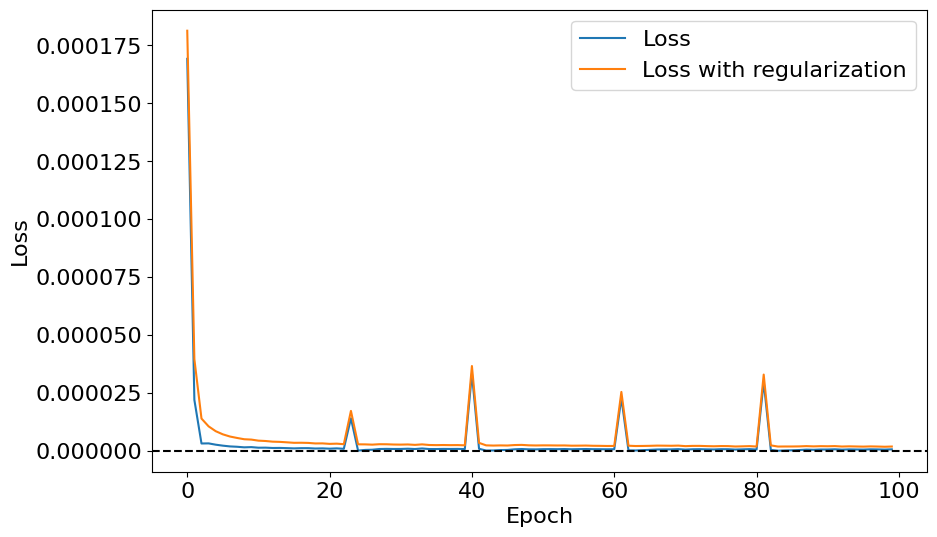

In [ ]:
# Make loss plot

plt.figure(figsize=(10, 6))

mean_total_losses = [total_loss/TRAIN_SIZE for total_loss in total_losses]
mean_total_losses_with_reg = [total_loss/TRAIN_SIZE for total_loss in total_losses_with_reg]

plt.plot(mean_total_losses, label='Loss')
plt.plot(mean_total_losses_with_reg, label='Loss with regularization')

plt.axhline(y=0, color='black', linestyle='--')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()

plt.show()

In [ ]:
# Get number of active layers of the student

active_layers = student_network.count_active_hidden_layers(TRIMMING_THRESHOLD)
print('Number of active layers:', active_layers)

Number of active layers: 2


In [ ]:
# Print the eigenvalues of the student

print('Eigenvalues of the student:\n')
print(f'l1 (max value: {torch.max(student_network.l1_diag).item()}):')
print(student_network.l1_diag)
print(f'l2 (max value: {torch.max(student_network.l2_diag).item()}):')
print(student_network.l2_diag)
print(f'l3 (max value: {torch.max(student_network.l3_diag).item()}):')
print(student_network.l3_diag)
print(f'l4 (max value: {torch.max(student_network.l4_diag).item()}):')
print(student_network.l4_diag)

Eigenvalues of the student:

l1 (max value: 0.00015717934002168477):
Parameter containing:
tensor([ 2.4615e-05, -1.8080e-04, -2.3994e-05, -2.0967e-04, -8.1350e-05,
        -3.0591e-04, -1.0374e-04, -3.5424e-04, -6.3257e-04, -3.1550e-04,
        -2.5422e-04, -1.3539e-04,  1.5718e-04, -1.2250e-05, -2.5584e-05,
        -2.5240e-04, -1.3992e-04, -1.8548e-04,  5.9865e-05, -2.9181e-04],
       device='cuda:0', requires_grad=True)
l2 (max value: 0.07068877667188644):
Parameter containing:
tensor([-1.8050e-05, -4.4370e-05, -2.0908e-05,  ...,  8.4536e-05,
         1.6281e-05,  1.6790e-05], device='cuda:0', requires_grad=True)
l3 (max value: 0.00032550733885727823):
Parameter containing:
tensor([-3.1375e-05, -7.3629e-05, -9.3182e-07,  ..., -1.3084e-06,
        -7.6644e-05, -1.4341e-05], device='cuda:0', requires_grad=True)
l4 (max value: 0.9027218222618103):
Parameter containing:
tensor([0.8604, 0.8248, 0.8068, 0.8632, 0.8465, 0.9027, 0.8624, 0.8227, 0.7998,
        0.8358, 0.7470, 0.8392, 0.814

In [ ]:
# Test the student network before trimming

student_network.eval()
with torch.no_grad():
    test_loss = 0
    for x_batch, y_batch in test_dataloader:
        y_pred = student_network(x_batch)
        loss = criterion(y_pred, y_batch)
        test_loss += loss.item()
    mean_test_loss_before_trimming = test_loss/TRAIN_SIZE
    print('Mean test loss before trimming:', mean_test_loss_before_trimming)

# Trim the student network and test again

number_of_trimmed_nodes = student_network.trim_inactive_nodes(TRIMMING_THRESHOLD)

with torch.no_grad():
    test_loss = 0
    for x_batch, y_batch in test_dataloader:
        y_pred = student_network(x_batch)
        loss = criterion(y_pred, y_batch)
        test_loss += loss.item()
    mean_test_loss_after_trimming = test_loss/TRAIN_SIZE
    print('Mean test loss after trimming:', mean_test_loss_after_trimming)

# Get percent increse in test loss after trimming

percent_increase = ((mean_test_loss_after_trimming - mean_test_loss_before_trimming)/mean_test_loss_before_trimming)*100
print('Percent increase in test loss after trimming:', percent_increase, '%')

# Get percent of trimmed nodes

total_number_of_trimmable_eigenvalues = TEACHER_LAYER_DIM + MAX_STUDENT_HIDDEN_DIMS*2
percent_of_trimmed_nodes = (number_of_trimmed_nodes/total_number_of_trimmable_eigenvalues)*100
print('Percent of trimmed nodes:', percent_of_trimmed_nodes, '%')

Mean test loss before trimming: 8.498648834938649e-07
Mean test loss after trimming: 8.497107014409267e-07
Percent increase in test loss after trimming: -0.018141948906556574 %
